In [1]:
import gc
from diffusers import AutoencoderKL, StableDiffusionXLControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

torch.cuda.empty_cache()

/home/tejag/software/comfyui/comfy-env/lib/python3.13/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/tejag/software/comfyui/comfy-env/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/tejag/software/comfyui/comfy-env/lib/python3.13/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/tejag/software/comfyui/comfy-env/lib/python3.13/site-packages/controlnet_aux/segment_anythi

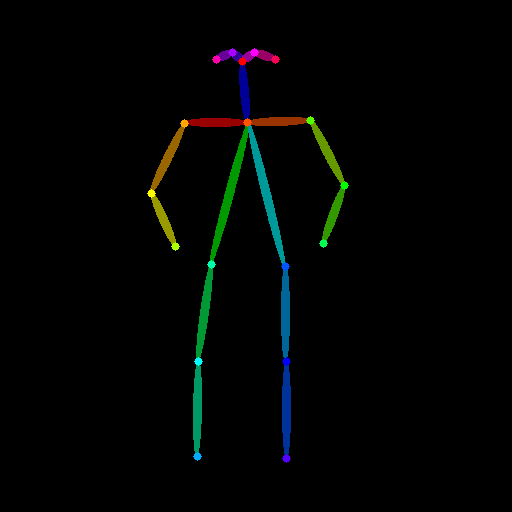

In [2]:
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image = openpose(image)
openpose_image

In [3]:
del openpose
gc.collect()
torch.cuda.empty_cache()

In [4]:
# Initialize ControlNet pipeline.
controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-openpose-sdxl-1.0", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
)
# https://www.felixsanz.dev/articles/ultimate-guide-to-optimizing-stable-diffusion-xl
# pipe.enable_sequential_cpu_offload()

pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()

An error occurred while trying to fetch thibaud/controlnet-openpose-sdxl-1.0: thibaud/controlnet-openpose-sdxl-1.0 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# Infer.
prompt = "Medieval barbarian warrior"
negative_prompt = "low quality, bad quality"
images = pipe(
    prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps=25,
    num_images_per_prompt=1,
    image=openpose_image.resize((768, 768)),
    generator=torch.manual_seed(97),
).images
images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 63.38 MiB is free. Including non-PyTorch memory, this process has 7.22 GiB memory in use. Of the allocated memory 6.85 GiB is allocated by PyTorch, and 214.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
del controlnet
del pipe
gc.collect()
torch.cuda.empty_cache()

NameError: name 'controlnet' is not defined

In [7]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   7009 MiB |   7009 MiB |  15223 MiB |   8214 MiB |
|       from large pool |   6914 MiB |   6914 MiB |  14120 MiB |   7205 MiB |
|       from small pool |     95 MiB |     95 MiB |   1103 MiB |   1008 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   7009 MiB |   7009 MiB |  15223 MiB |   8214 MiB |
|       from large pool |   6914 MiB |   6914 MiB |  14120 MiB |

In [10]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()
    
    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% |  6% |
